In [85]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import pandas as pd
import openpyxl
import scipy.optimize

from scipy.stats import norm
from scipy.stats import t
from scipy.stats import chi2

# Espectros A

In [86]:
def Minimos_cuadrados(x,y,n=1):
    l = x.shape[0]
    b = y
    
    A = np.ones((l,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**i
        
    AT = np.dot(A.T,A)
    bT = np.dot(A.T,b)

    xsol = np.linalg.solve(AT,bT)
    
    return xsol

def GetModel(x,p):
    
    y = 0.
    for i in range(len(p)):
        y += p[i]*x**i
        
    return y

def GetError(x,y,p,n=1):
    
    l = x.shape[0]
    
    A = np.ones((l,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**i
        
    # Residuos
    R = y - np.dot(A,p)
    
    sigma2 = np.dot(R.T,R)/(len(y)-len(p))
    
    Cov = sigma2*np.linalg.inv(np.dot(A.T,A))
    
    R2 = None
    if np.shape(Cov) == (2,2):
        R2 = (Cov[0][1]**2)/(Cov[0][0]*Cov[1][1])

    return (Cov,R2,R)

def Get_sigma(Cov):
    sigmaai = np.sqrt(np.diagonal(Cov))
    return sigmaai[::-1]

def Error_relativo(X_real,X_exp):
    return (np.abs(X_exp - X_real)/X_real)

def presicion(d,v):
    p = (d/v)
    if p <= 0.1:
        return p,True
    else:
        return p,False
    
def exactitud(xr,xm,d):
    e = (np.abs(xr-xm))
    if e <= (2.5*d):
        return e/d,True
    else:
        return e/d,False

X = sym.Symbol('x',real=True)
Y = sym.Symbol('y',real=True)

In [87]:
c = 299798458*1e09 #nm/s
c_ = 299798458 #m/s
me = 0.51099895*1e06/(c**2) #eV/c**2
me_ = 0.51099895*1e06/(c_**2) #eV/c**2
mp = 938.27208816*1e06/(c**2) #eV/c**2
mn = 939.56542052*1e06/(c**2) #eV/c**2
h = 4.136667696*1e-15 #eV*s
h_barra = 6.582119569*1e-16 #eV*s
e_0 = 55.26349406*1e-03 #e**2/(cV*nm)
e = 1 #e
a_0 = 0.0529177210903 #nm
Ry = 13.605693122994 #eV
Miu_B = 5.7883818066*1e-05 #eV/T

# Datos

In [88]:
H_ = np.array([434.0472, 486.1298, 656.279])
err_angulo = 0.05

Prisma:

In [89]:
a = np.pi/3
P = np.array([40.4, 40., 39.1])*(np.pi/180)

Rejilla:

In [90]:
R = np.array([14.2, 16., 22.3])*(np.pi/180)

Sodio:

In [91]:
S = 19.8*(np.pi/180)

# Análisis

Índice de refracción del prisma

In [92]:
def indice_n (d):
    return (np.sin((a+d)/2))*2

def err_n (d):
    return (np.cos((a+d)/2))*err_angulo

n = indice_n(P)
e_n = err_n(P)
e_n

array([0.03200548, 0.03213938, 0.03243921])

Text(0.5, 1.0, 'Índice de refracción según longitud de onda')

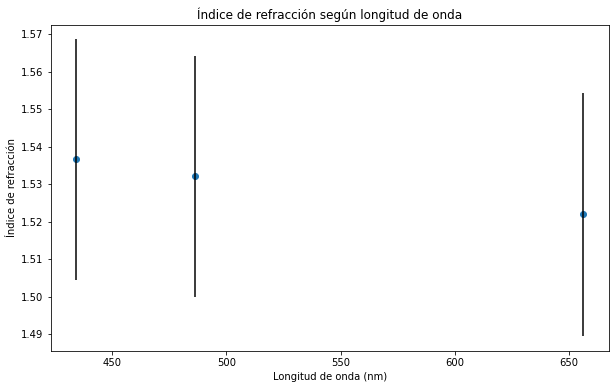

In [93]:
plt.figure(figsize=(10,6))
plt.scatter(H_,n)
plt.errorbar(H_,n, yerr= e_n, fmt='none', ecolor='black')
plt.ylabel('Índice de refracción')
plt.xlabel('Longitud de onda (nm)')
plt.title('Índice de refracción según longitud de onda')

Text(0.5, 1.0, 'Índice de refracción según el inverso de longitud de onda al cuadrado')

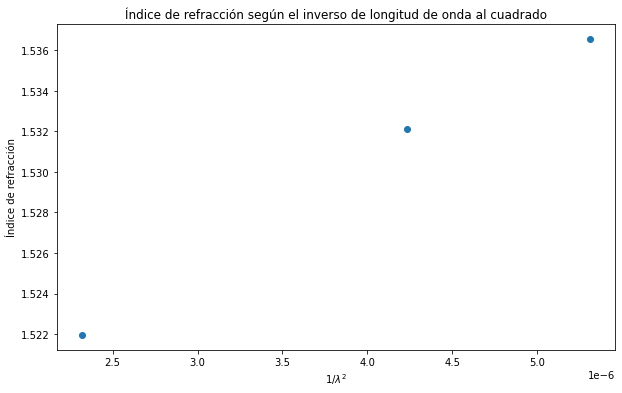

In [94]:
inv_cuadrado = 1/(H_**2)
plt.figure(figsize=(10,6))
plt.scatter(inv_cuadrado,n)
plt.ylabel('Índice de refracción')
plt.xlabel(r'$1/\lambda^{2}$')
plt.title('Índice de refracción según el inverso de longitud de onda al cuadrado')

Ajustes

In [95]:
def ajuste_1 (H_,A,B):
    return A + B/(H_**2)
popt, pcov = scipy.optimize.curve_fit(ajuste_1,H_,n)
A,B = popt
perr = np.sqrt(np.diag(pcov))
fitfunc = lambda H_: A + B/(H_**2)
(A,B)

(1.5106497366102063, 4944.8087704389045)

In [96]:
pcov

array([[ 1.53171615e-06, -3.52979014e-01],
       [-3.52979014e-01,  8.92770647e+04]])

In [97]:
perr

array([1.23762521e-03, 2.98792678e+02])

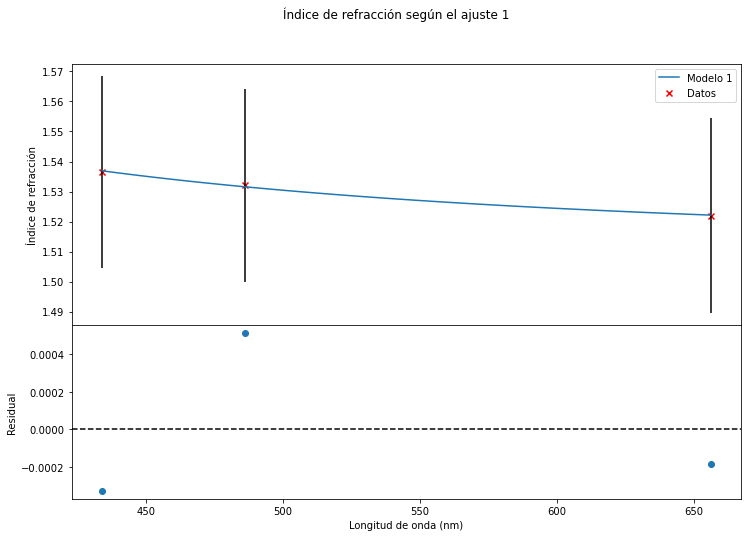

In [98]:
x_ = np.linspace(np.min(H_),np.max(H_),50)

fig, axs = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [1.5, 1]},sharex=True)
fig.subplots_adjust(hspace=0)
fig.suptitle('Índice de refracción según el ajuste 1')

axs[0].scatter(H_,n,label='Datos',color='r',marker='x')
axs[0].plot(x_,fitfunc(x_),label='Modelo 1')
axs[0].errorbar(H_,n, yerr= e_n, fmt='none', ecolor='black')
axs[0].set_ylabel('Índice de refracción')
axs[0].legend()

axs[1].scatter(H_,n-fitfunc(H_))
axs[1].axhline(y=0, color='black', linestyle='--')
axs[1].set_xlabel('Longitud de onda (nm)')
axs[1].set_ylabel('Residual')

plt.show()

Ajuste 2

In [99]:
def ajuste_2 (H_,A_,B_,C_):
    return A_ + B_/(H_**2) + C_/(H_**4)
popt, pcov = scipy.optimize.curve_fit(ajuste_2,H_,n)
A_,B_,C_ = popt
perr = np.sqrt(np.diag(pcov))
fitfunc_2 = lambda H_: A + B/(H_**2) + C_/(H_**4)
(A_,B_,C_)

c:\Users\ASUS\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(1.510649736681317, 4944.808748623447, 1.0)

In [100]:
pcov

array([[inf, inf, inf],
       [inf, inf, inf],
       [inf, inf, inf]])

In [101]:
perr

array([inf, inf, inf])

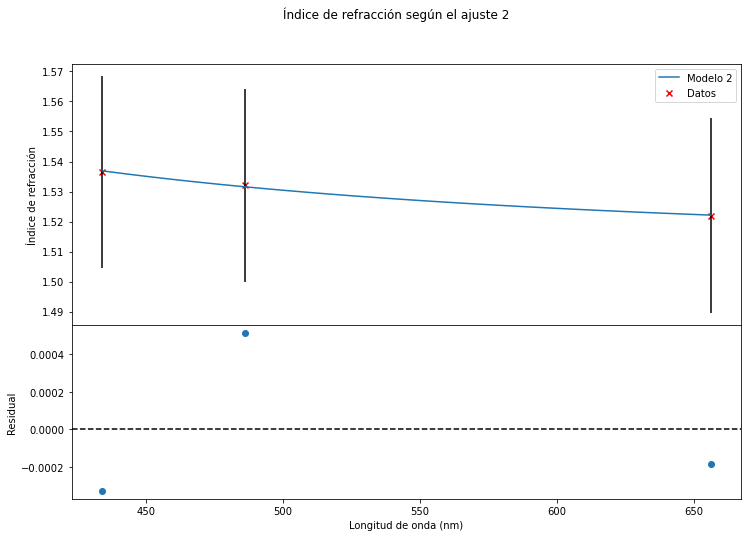

In [102]:
x_ = np.linspace(np.min(H_),np.max(H_),50)

fig, axs = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [1.5, 1]},sharex=True)
fig.subplots_adjust(hspace=0)
fig.suptitle('Índice de refracción según el ajuste 2')

axs[0].scatter(H_,n,label='Datos',color='r',marker='x')
axs[0].plot(x_,fitfunc_2(x_),label='Modelo 2')
axs[0].errorbar(H_,n, yerr= e_n, fmt='none', ecolor='black')
axs[0].set_ylabel('Índice de refracción')
axs[0].legend()

axs[1].scatter(H_,n-fitfunc_2(H_))
axs[1].axhline(y=0, color='black', linestyle='--')
axs[1].set_xlabel('Longitud de onda (nm)')
axs[1].set_ylabel('Residual')

plt.show()

Constante de Rydberg prisma modelo 1.

In [103]:
def lambdas (n):
    return np.sqrt(B/(n-A))

def err_lamb (n,err_n):
    return 0.5*((B/(n-A))**(-0.5))*(B/((n-A)**2))*err_n

l = lambdas(n)
e_l = np.array([err_lamb(n[0],e_n[0]), err_lamb(n[1],e_n[1]), err_lamb(n[2],e_n[2])])
l

array([436.7971378 , 480.25398013, 661.65165317])

In [104]:
xR = []
for i in range(5,2,-1):
    xR.append((1/(2**2)) - (1/(i**2)))
xR = np.array(xR)
xR

array([0.21      , 0.1875    , 0.13888889])

In [105]:
l_i = 1/l
l_i

array([0.00228939, 0.00208223, 0.00151137])

In [106]:
param = Minimos_cuadrados(xR,l_i)
param

array([-1.81810851e-05,  1.10694620e-02])

In [109]:
Cov,R2,r = GetError(xR,l_i,param)
deltas = Get_sigma(Cov)
deltas

array([0.00060621, 0.00010987])

In [110]:
R2

0.9731900154587662

In [111]:
_x = np.linspace(np.min(xR),np.max(xR),50)
_y = GetModel(_x,param)

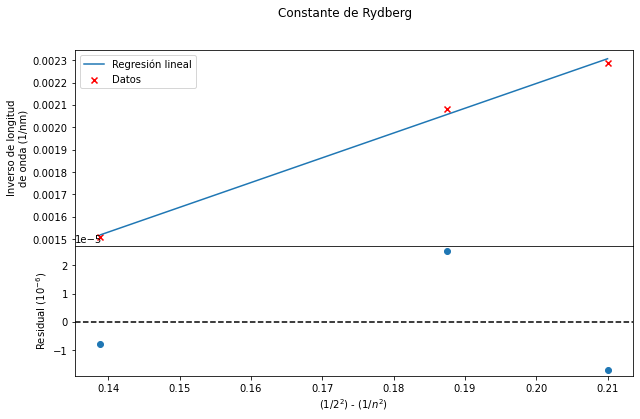

In [112]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1.5, 1]},sharex=True)
fig.subplots_adjust(hspace=0)
fig.suptitle('Constante de Rydberg')

axs[0].scatter(xR,l_i,label='Datos',color='r',marker='x')
#axs[0].errorbar(xR, l_i,yerr= error_y, fmt='none', ecolor='black')
axs[0].plot(_x,_y,label='Regresión lineal')
axs[0].set_ylabel('Inverso de longitud\nde onda (1/nm)')
#axs[0].text(0.184,0.00152,'m = (109e-04 $\pm$ 2e-04)\nb = (0.6e-05 $\pm$ 2.8e-05)\n$R^{2} = 0.973$',fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
axs[0].legend()

axs[1].scatter(xR,r)
axs[1].axhline(y=0, color='black', linestyle='--')
axs[1].set_xlabel('(1/$2^{2}$) - (1/$n^{2}$)')
axs[1].set_ylabel('Residual ($10^{-6}$)')
#axs[1].set_ylim(-6.,7.5)
#axs[1].set_yticks(np.arange(-4.5, 7., 1.5))

plt.show()

In [113]:
R = param[1]*1e+9
R

11069462.002982354

In [115]:
dR = deltas[0]*1e+9
dR

606209.0777778008

In [116]:
Rr = 1.0973731568539*1e+7
Rr

10973731.568539001

In [117]:
Error_relativo(Rr,R)

0.008723599064315177

In [118]:
exactitud(Rr,R,dR)

(0.1579165307030286, True)

In [119]:
presicion(dR,R)

(0.054764095817346405, True)